In [2]:
import numpy as np
from scipy.constants import c
from tqdm.notebook import tqdm
import h5py as hp
import matplotlib.pyplot as plt
from aps_figures.aps_one_column import *
from FITX import fit_risetime
from machine_data.TDR2 import *
from postprocessing import *
from mbtrack2 import Synchrotron, Electron
from mbtrack2.utilities import Optics
from machine_data.soleil import v2366, v2366_v2
import matplotlib.pyplot as plt
from aps_figures.aps_one_column import *

In [21]:
ring2 = v2366(IDs='close', load_lattice=False)
chro = [0.0, 0.0]
ring = Synchrotron(h=ring2.h, optics=ring2.optics, particle=Electron(), L=ring2.L, E0=ring2.E0, ac=ring2.ac, 
                   U0=ring2.U0, tau=ring2.tau, emit=ring2.emit, tune=ring2.tune, 
                   sigma_delta=ring2.sigma_delta, sigma_0=ring2.sigma_0, chro=chro)
Q_S = ring.synchrotron_tune(1.8e6)


In [22]:
%matplotlib inline
n_macroparticles=1e6
n_turns = 5e4
n_bin = 100
bunch_current = 1.4e-3
Qp_x = 0.0
Qp_y = 0.0

ID_state = 'close'
Zlong='True'
cavity='False'
tmci_current = 1e-3*np.linspace(0.2, 7, 35)
# tmci_current  = 1e-3*np.linspace(0.2, 10, 50)
risetimes = []
peak_freqsarr = []
peak_ampsarr = []
sigmas_dp = []
sigmas_dp_min = []
sigmas_dp_max = []

sigmas_z = []

for bunch_current in tqdm(tmci_current):
    try:
        risetime, peak_freqs, peak_amps, final_energy_offset, max_energy_offset, min_energy_offset, final_bunch_length = post_single(n_macroparticles,
                    n_turns, 
                    n_bin,
                    bunch_current, 
                    Qp_x,
                    Qp_y,
                    ID_state,
                    Zlong,
                    cavity)
    except:
        risetime = peak_freqs = peak_amps = final_energy_offset = max_energy_offset = min_energy_offset = final_bunch_length = np.nan
    risetimes.append(risetime)
    peak_freqsarr.append(peak_freqs)
    peak_ampsarr.append(peak_amps)
    sigmas_dp.append(final_energy_offset)
    sigmas_z.append(final_bunch_length)    
    sigmas_dp_min.append(min_energy_offset)
    sigmas_dp_max.append(max_energy_offset)
    

  0%|          | 0/35 [00:00<?, ?it/s]

In [24]:
%matplotlib inline
risetimes = np.array(risetimes)
indices = np.isnan(risetimes)
print(risetimes[indices])
risetimes[np.isnan(risetimes)] = np.inf

[]


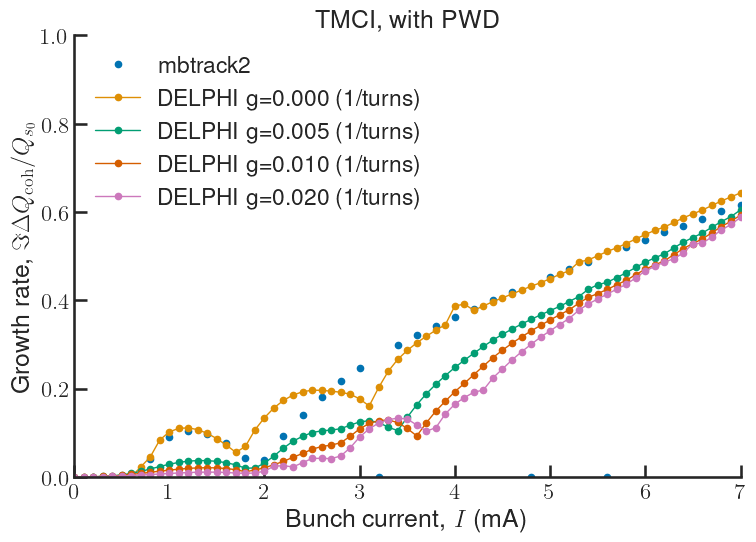

In [31]:
Q_s0 = 2.1e-3
sbs.color_palette('colorblind')
plt.plot(tmci_current*1e3, 1/(2*np.pi*risetimes*Q_s0), lw=0, marker='.', label='mbtrack2')
ximp = 1.0
sig_z = 23e-12
Q_s = .95e-3
# colors = ['r',]
for damper_gain in [0, 5e-3, 1e-2, 2e-2]:
    df = pd.read_csv(f'~/scripts/analytical/delphi/data/tmp/delphi(sigma_z={sig_z:.1e},ID=close,plane=vertical,Qp=0.0,M=1,Q_s={Q_s:.1e},n_max=0,damper_gain={damper_gain:.1e},ximpedance={ximp:.1f}).csv', sep='\t')
    df['BunchLength'].unique()/4
    df = df.drop_duplicates(['BunchCurrent'], keep='first')
    plt.plot(df['BunchCurrent']/1e-3, -df['eigvals_im']/Q_s0, lw=1, marker='.',
             label=f'DELPHI g={damper_gain:.3f} (1/turns)',
             # label=f'DELPHI',
             # color='r'
            )
plt.xlim(0, 7)
plt.ylim(0, 1)
plt.xlabel('Bunch current, $I$ (mA)')
plt.ylabel('Growth rate, $\Im\Delta Q_\mathrm{coh}/Q_{s_0}$')
# plt.ylabel('Growth rate, $\\tau^{-1}$ (1/turns)')

plt.title('TMCI, with PWD')
plt.legend()
# plt.savefig('../../data/processed/tmci_pwd_fb.png')
# plt.savefig('../../data/processed/tmci_pwd_fb.pdf')

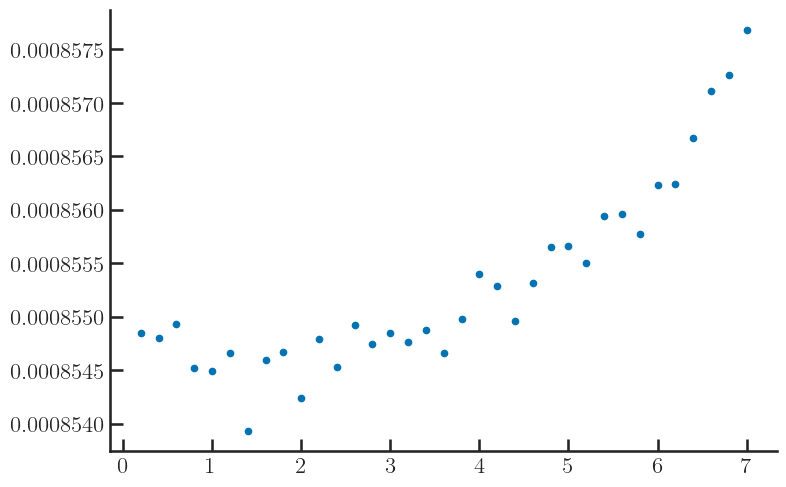

In [62]:
a = pd.DataFrame({'current': tmci_current*1e3, 'rms_bunch_length': sigmas_z, 'rms_energy_spread': sigmas_dp})
# a.loc[17, 'rms_energy_spread'] = np.nan
a['rms_energy_spread'] = a['rms_energy_spread'].interpolate()
plt.plot(tmci_current*1e3, a['rms_energy_spread'], marker='.', linewidth=0)


In [63]:
%matplotlib inline
# a.loc[17, 'rms_bunch_length'] = np.nan
# a.loc[1, 'rms_bunch_length'] = np.nan
a['rms_bunch_length'] = a['rms_bunch_length'].interpolate()
b = pd.concat([pd.DataFrame({'current': [0], 'rms_bunch_length': [ring.sigma_0], 'rms_energy_spread': [ring.sigma_delta]}), a])

(0.0, 7.34)

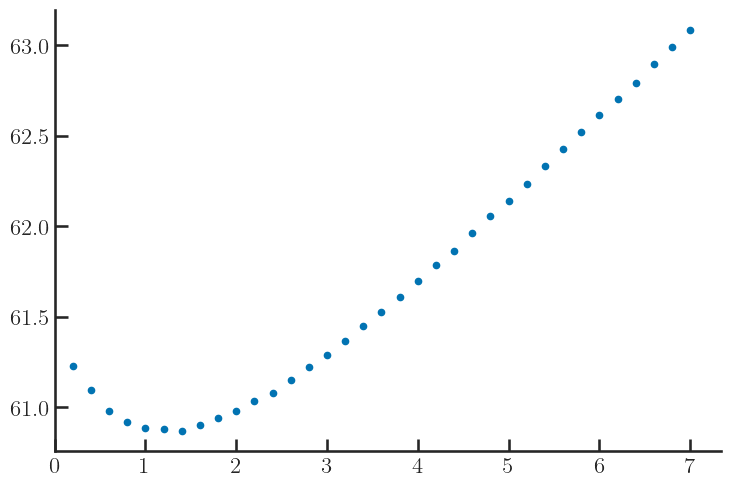

In [67]:
plt.plot(tmci_current*1e3, np.array(sigmas_z)/1e-12, marker='.', linewidth=0)
# sigz = np.load('/home/gubaidulin/scripts/analytical/delphi/input/sigmas_zlong.txt')
# plt.plot(np.linspace(0, 5e-3, 51)/1e-3, sigz/1e-12)
plt.xlim(0, )
# plt.ylim(0, )
# plt.plot(tmci_current*1e3, np.array(sigmas_z)/1e-12)


0.0008547


/tmp/ipykernel_2041601/3582196253.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  b['rms_energy_spread'][0] = ring.sigma_delta
/tmp/ipykernel_2041601/3582196253.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas

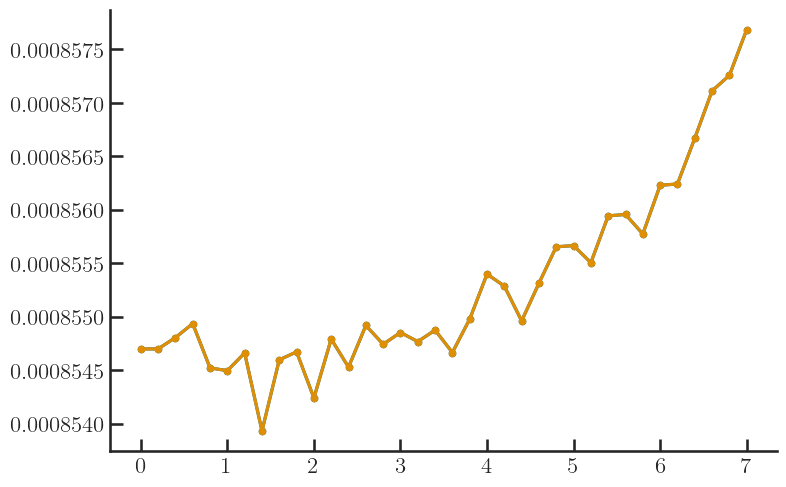

In [72]:
# plt.plot(b['current'], b['rms_bunch_length']/1e-12, marker='.')
plt.plot(b['current'], b['rms_energy_spread'], marker='.')
from machine_data import v2366_v3
ring = v2366_v3(IDs = 'close')
b['rms_energy_spread'][0] = ring.sigma_delta
b['rms_bunch_length'][0] = 61.55e-12

# b.to_csv('/home/gubaidulin/scripts/analytical/delphi/input/sigmas_hc.txt', sep='\t')
print(ring.sigma_delta)
plt.plot(b['current'], b['rms_energy_spread'], marker='.')


[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4
 3.6 3.8 4.  4.2 4.4 4.6 4.8 5.  5.2 5.4 5.6 5.8 6.  6.2 6.4 6.6 6.8 7. ] [6.20000000e-11 6.15500000e-11 6.10922312e-11 6.09800156e-11
 6.09164958e-11 6.08867775e-11 6.08772237e-11 6.08687595e-11
 6.09001685e-11 6.09374788e-11 6.09768376e-11 6.10325046e-11
 6.10801326e-11 6.11497041e-11 6.12193079e-11 6.12900377e-11
 6.13675350e-11 6.14468726e-11 6.15267673e-11 6.16112022e-11
 6.16973091e-11 6.17857951e-11 6.18633138e-11 6.19635078e-11
 6.20539314e-11 6.21413167e-11 6.22302660e-11 6.23330496e-11
 6.24244994e-11 6.25179276e-11 6.26124590e-11 6.27034638e-11
 6.27915869e-11 6.28932116e-11 6.29872451e-11 6.30851154e-11]


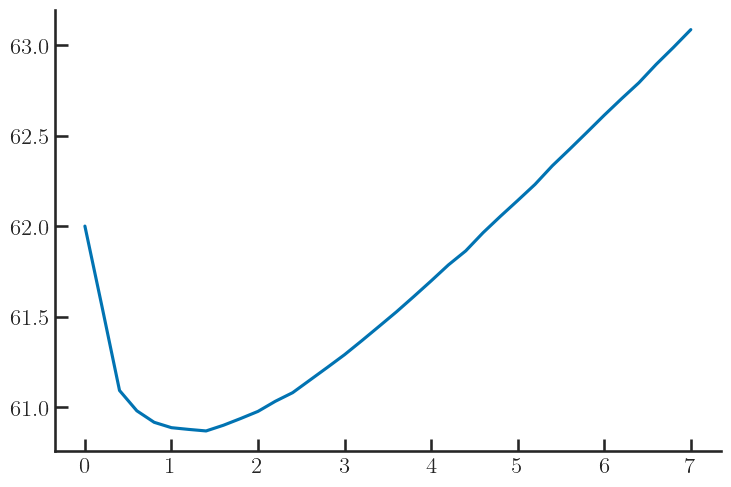

In [74]:
df_input = np.loadtxt('/home/gubaidulin/scripts/analytical/delphi/input/sigmas_hc.txt', delimiter='\t', usecols=(1, 2), dtype=np.float64, skiprows=1)
(Ib, sigmas) = df_input.T
print(Ib, sigmas)
from scipy.interpolate import interp1d
interp1d(Ib, sigmas)(0.1e-3)
plt.plot(Ib, sigmas*1e12)

In [76]:
n_macroparticles = 1e6
n_turns = 6e4
# n_turns_wake = 50
Qp_x = 0.0
Qp_y = 0.0
id_state = 'close'
include_Zlong = 'True'
harmonic_cavity = 'False'
bunch_current = 1.0e-3
max_kick = 0.0
folder = '/home/gubaidulin/scripts/tracking/transverse_instabilities/data/raw/newest/'
filename = (folder+
            f'monitors(n_mp={n_macroparticles:.1e},'+
            f'n_turns={n_turns:.1e},'+
            f'n_bin=100,bunch_current={bunch_current:.1e},'+
            f'Qp_x={Qp_x:.2f},Qp_y={Qp_y:.2f},id_state={id_state:},'+
            f'Zlong={include_Zlong:},'+
            f'cavity={harmonic_cavity:},'+
            f'max_kick={max_kick:.1e}'+
            ').hdf5')
f = hp.File(filename
           )
print(f.keys())
y = f['BunchData_0']['mean'][2, :]
yp = f['BunchData_0']['mean'][3, :]
sig_z = f['BunchData_0']['std'][4, :]
Jy = f['BunchData_0']['cs_invariant'][1, :]
y = np.trim_zeros(y)
yp = np.trim_zeros(yp)

sig_y = f['BunchData_0']['std'][2, 0]
turns = np.linspace(0, n_turns, y.shape[0])
fig, ax = plt.subplots(1, 1)

risetime = plot_offset(ax,
            m=y,
            mp=yp,
            std=sig_y,
            n_macroparticles=n_macroparticles,
            n_turns=n_turns,
            n_bin=100,
            bunch_current=bunch_current,
            Qp_x=1.6,
            Qp_y=1.6,
            n_bunches=1,
            n_sampling = 1)
dQcoh = 1/(2*np.pi*risetime)
print(f'Coherent tune shift is {(dQcoh/Q_S):.1e}')
ring = v2366_v2(IDs=id_state)
dQrad = 1/(ring.tau[1]*ring.omega0)
print(f'Threshold current is {500/dQcoh*dQrad:.1f} mA')
print(f'Synchrotron period in turns {1/(2*np.pi*ring.synchrotron_tune(1.8e6)):.1f}')
ax.set_xlim(0, 2e4)
ax.set_ylim(-1e4, 1e4)
# plt.savefig(f'/home/gubaidulin/scripts/tracking/transverse_instabilities/data/processed/offset(Qp={Qp_y:.1f},n_turns_wake={n_turns_wake:}).png')
f.close()

<KeysViewHDF5 ['BunchData_0', 'WakePotentialData_0']>
Coherent tune shift is 8.4e-02
Threshold current is 55.8 mA
Synchrotron period in turns 76.9


(-1.0, 1.0)

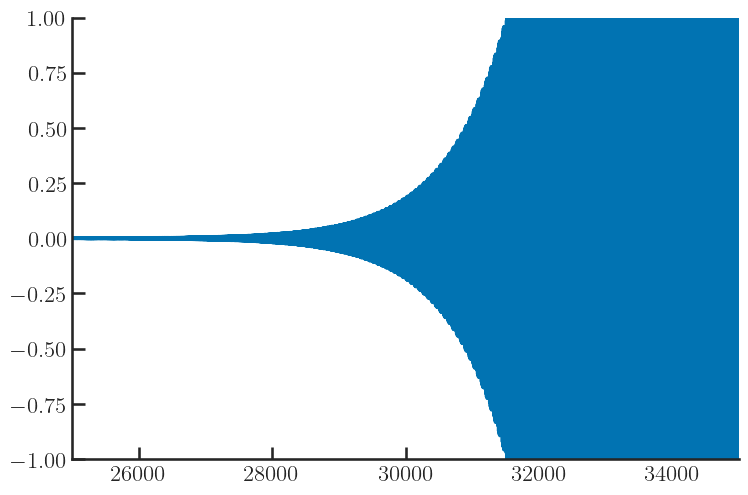

In [77]:
%matplotlib inline
plt.plot(y/sig_y)
# plt.plot(sig_z/1e-12)
plt.xlim(25_000, 35_000)
plt.ylim(-1, 1)

In [55]:
with hp.File(filename) as f:
    print(f.keys())
    print(f['BunchData_0'].keys())
    print(f['WakePotentialData_0'].keys())
    m = f['BunchData_0']['mean'][:]
    std = f['BunchData_0']['std'][:]
    J = f['BunchData_0']['cs_invariant'][:]
    emit = f['BunchData_0']['emit'][:]
    p = f['WakePotentialData_0']['profile_Wydip'][:]
    tau = f['WakePotentialData_0']['tau_Wydip'][:]
    t = f['WakePotentialData_0']['time'][:]
    
    dip = f['WakePotentialData_0']['dipole_Wydip'][:]
    Wdip = f['WakePotentialData_0']['Wydip'][:]    
    time = f['WakePotentialData_0']['time'][:]

<KeysViewHDF5 ['BunchData_0', 'WakePotentialData_0']>
<KeysViewHDF5 ['cs_invariant', 'current', 'emit', 'mean', 'std', 'time']>
<KeysViewHDF5 ['Wydip', 'dipole_Wydip', 'profile_Wydip', 'tau_Wydip', 'time']>


(0.0, 60000.0)

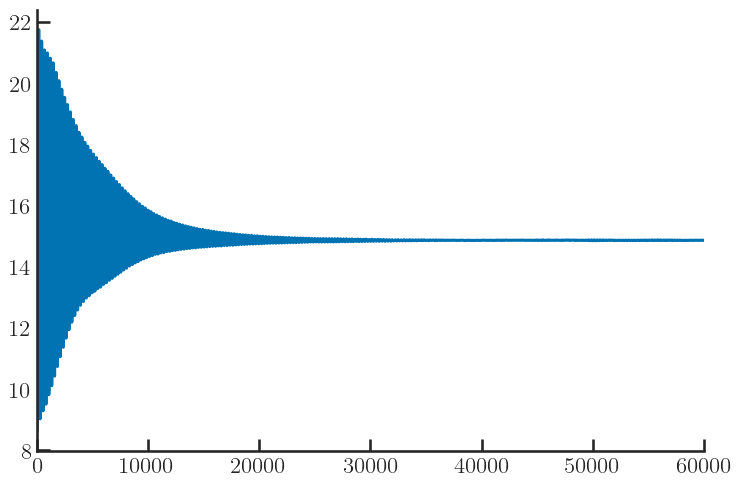

In [56]:
plt.plot(std[4, :]/1e-12)
plt.xlim(0, 60_000)
# plt.ylim(1, 2)

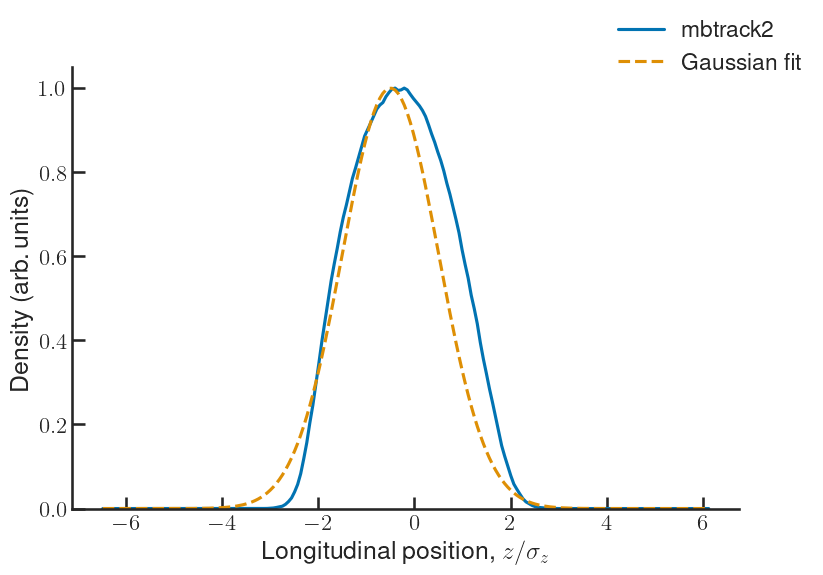

In [57]:
%matplotlib inline
from scipy.interpolate import interp1d


t = tau[:, 0]/std[4, 20000]
p_norm = p[:, 0]/np.max(p[:,0])
t0 = np.linspace(-5, 5, 5000)
interp_fit = interp1d(t, p_norm)
# r2, popt = fit_loop(t0, interp_fit(t0))
fig, ax = plt.subplots(1, 1)
ax.plot(t, p_norm, label='mbtrack2')
plt.plot(t, np.exp(-.5*(t+.5)**2), linestyle='dashed', label='Gaussian fit')
# ax.plot(t0, laguerre_fit(t0, *popt), linestyle='dashdot', label='Laguerre fit')
ax.set_xlabel('Longitudinal position, $z/\sigma_z$')
ax.set_ylabel('Density (arb.\,units)')

# ax.set_xlim(-4, 4)
ax.set_ylim(0, )
plt.figlegend()
# print("R-squared is {:.5f}".format(r2))
# plt.savefig('/hom

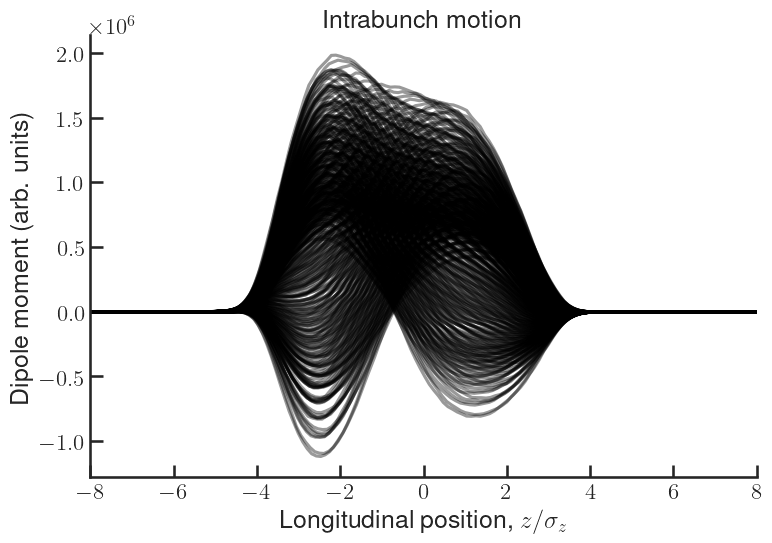

In [58]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
linenumber = 50
linestart = 2000
lineend =2400
ax.plot(tau[:,linestart:lineend]*c/SIGMA_Z, dip[:,linestart:lineend]*p[:,linestart:lineend],
        color='black', alpha=0.4)
ax.set_xlim(-8, 8)
ax.set_xlabel('Longitudinal position, $z/\sigma_z$')
ax.set_ylabel('Dipole moment (arb. units)')
# ax.title.set_text('Intrabunch motion for last {:} turns, N_m={:.1e}'.format(linenumber, n_macroparticles))
ax.title.set_text('Intrabunch motion')

In [218]:
# tau.shape
# for i in range(0, 500):
    # plt.plot(tau[:,i]/1e-12, (dip[:, i]), color='b', alpha=0.1)